# Definición de funciones previas


In [ ]:
import pandas as pd
def load_prepare_data(path):
  """
  Función para cargar y procesar datos para el ejercicio.
  """
  df = pd.read_csv(path,sep=",")
  map_classes = {
    "religion":1,
    "age":1,
    "ethnicity":1,
    "gender":1,
    "other_cyberbullying":1,
    "not_cyberbullying":0,
  }
  df["cyberbullying"] = df.cyberbullying_type.map(map_classes)
  return df[["tweet_text","cyberbullying"]].copy()

## 0. Importaciones e instalaciones


In [ ]:
import sys
!{sys.executable} -m pip install contractions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contractions
import seaborn as sns
import nltk
import scipy as sp


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
    )

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix

from wordcloud import WordCloud
nltk.download('stopwords')
from nltk.corpus import stopwords
!pip install spacy==3.2.1
!python -m spacy download en_core_web_sm
import en_core_web_sm
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from imblearn.over_sampling import SMOTE
import warnings

## 1. Obtención del corpus
Ejecutamos la función `load_prepare_data()`, definida previamente, con el fin de cargar rapidamente los datos remapeando las categorias de la variable cyberbullying para obtener una columna con el tweet y otra binaria de presencia de cyberbullying



In [ ]:
path_data = "https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/cyberbullying_tweets.csv"
dataset = load_prepare_data(path_data)

In [ ]:
dataset.head(4)

,tweet_text,cyberbullying
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0


## 2. Análisis exploratorio

### Conteo de elementos antes y después de la eliminación de duplicados

In [ ]:
corpus_tweet = dataset["tweet_text"].tolist()
print(type(corpus_tweet))
print('El corpus "corpus_tweet" contiene un total de {} documentos'.format(len(corpus_tweet)))
print("El dataframe tiene {} columnas".format(dataset.shape[1]))

<class 'list'>
El corpus "corpus_tweet" contiene un total de 47692 documentos
El dataframe tiene 2 columnas


In [ ]:
print("Existen {} documentos duplicadas".format(np.sum(dataset.duplicated(subset=["tweet_text"]))))

Existen 1675 documentos duplicadas


In [ ]:
dataset = dataset.drop_duplicates()
print("Despues de quitar duplicados tenemos un conjunto de {} documentos".format(dataset.shape[0]))

Despues de quitar duplicados tenemos un conjunto de 47526 documentos


La diferencia entre el numero de documentos duplicados y la resta del total original menos el total al quitarlos se presupone que es por la existencia de documentos que a pesar de ser iguales toman valores distintos en la columna *cyberbullying*. Es decir, que los responsables de clasificar el tweet como *cyberbullying* difieren en conclusiones.

### Comprobación del balance de la muestra

In [ ]:
dataset.groupby(['cyberbullying']).count()

,tweet_text
cyberbullying,
0,7937
1,39589


La muestra está notablemente desbalanceada entorno a las clases.

### Creación de una variable que refleje el número de caracteres de cada tweet, análisis de su distribución con respecto a la variable dependiente, tratamiento de outliers y creación de una variable binaria entorno a una condición de cantidad de la anterior.

In [ ]:
dataset["len_char_txt"]=dataset["tweet_text"].apply(len)
dataset.head(4)

<ipython-input-10-6ee06c9da584>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["len_char_txt"]=dataset["tweet_text"].apply(len)


,tweet_text,cyberbullying,len_char_txt
0,"In other words #katandandre, your food was cra...",0,61
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,115
2,@XochitlSuckkks a classy whore? Or more red ve...,0,60
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0,103


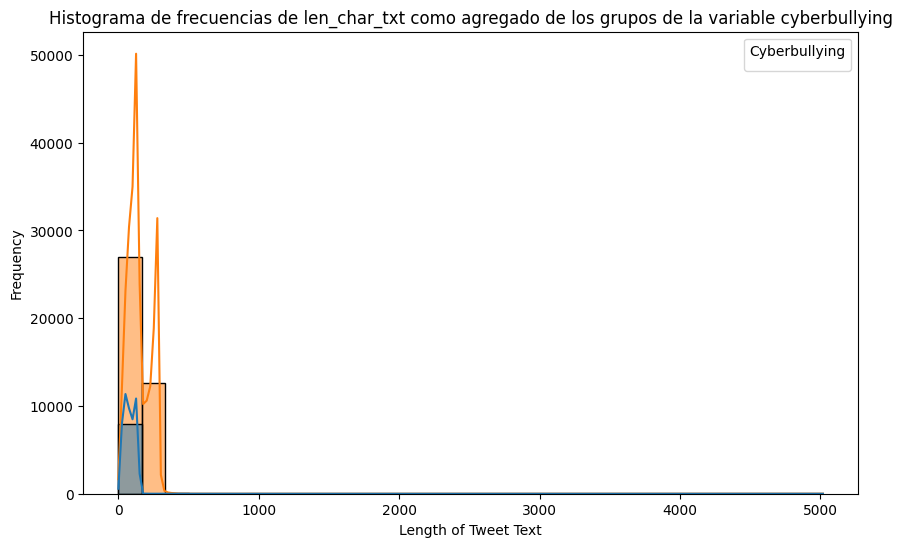

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=dataset, x="len_char_txt", hue="cyberbullying", bins=30, kde=True, legend=True)

plt.xlabel("Length of Tweet Text")
plt.ylabel("Frequency")
plt.title("Histograma de frecuencias de len_char_txt como agregado de los grupos de la variable cyberbullying")
plt.legend(title="Cyberbullying")
plt.show()

Aunque no es la mejor forma de visualizarlo, la representación predeterminada nos da un indicio de la presencia de outliers de len_char_txt en la muestra

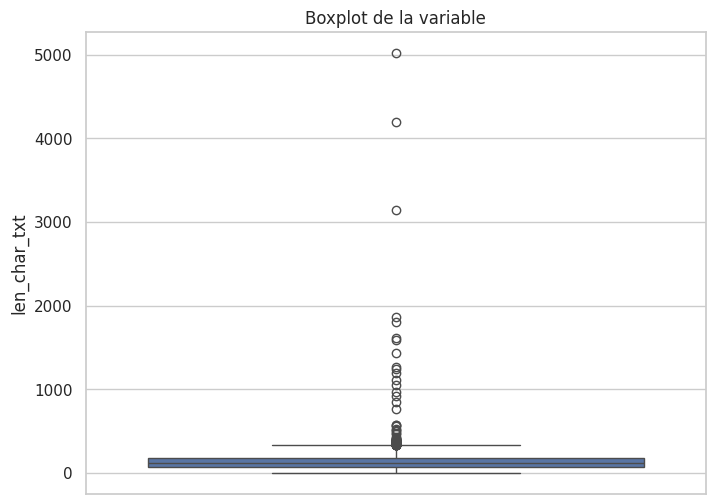

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
boxplot = sns.boxplot(y=dataset["len_char_txt"])
plt.title("Boxplot de la variable")
plt.show()
whiskers_pos = [whiskers.get_ydata() for whiskers in boxplot.lines[-2:]]

Tomamos la decisión de dejar a un margen de la muestra los documentos cuyo numero de caracteres sea un outlier

In [ ]:
q1 = np.quantile(dataset["len_char_txt"], 0.25)
q3 = np.quantile(dataset["len_char_txt"], 0.75)
iqr = q3-q1
bigote_superior = q3+(1.5*iqr)

dataset_outlier = dataset['len_char_txt'] >= bigote_superior
dataset = dataset.drop(dataset[dataset_outlier].index)

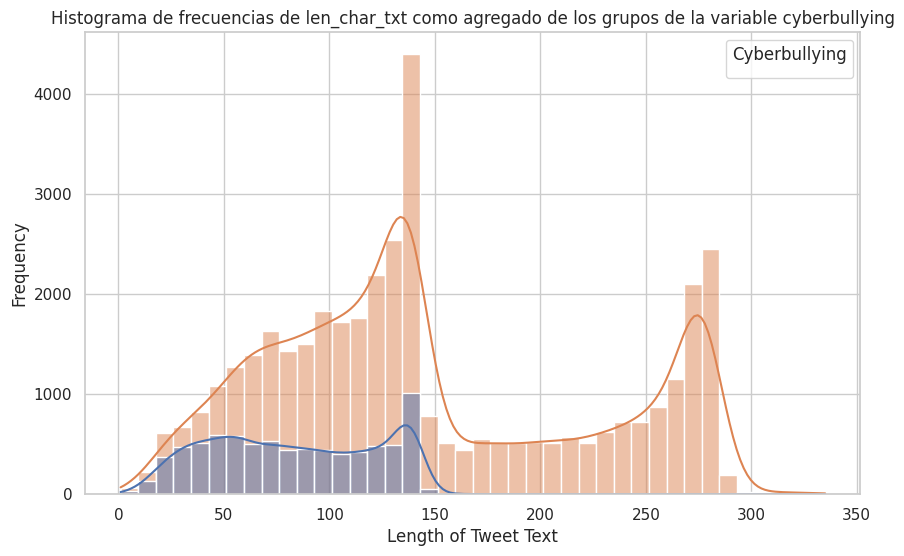

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=dataset, x="len_char_txt", hue="cyberbullying", bins=40, kde=True, legend=True)

plt.xlabel("Length of Tweet Text")
plt.ylabel("Frequency")
plt.title("Histograma de frecuencias de len_char_txt como agregado de los grupos de la variable cyberbullying")
plt.legend(title="Cyberbullying")
plt.show()

Tras la representación del histograma con la supresión de los outliers de longitud de carcteres observamos que hay una fuerte influencia por parte de una hipotética variable dummy de longitud>150 que decidimos añadir al dataset.

In [ ]:
dataset["len_150"] = dataset["len_char_txt"].apply(lambda x: 0 if x < 150 else 1)
dataset.groupby("len_150").count()

,tweet_text,cyberbullying,len_char_txt
len_150,,,
0,33733,33733,33733
1,13716,13716,13716


### Creación de wordclouds de la muestra agrupada entorno a la variable dependiente

Obtenemos, previa tokenización y filtración, una nube de palabras de los tweets contenidos en cada categoría a estimar.

Nótese la aparición de palabras como http, que denota una url que luego se clasificará y se contabilizará como variable al margen de la tokenización, o contracciones como I'm, que muestra la necesidad de arreglar contracciones y desprenderse de artículos y/o palabras sin un aporte sustancial

In [ ]:
txt_cb1 = ",".join(dataset[dataset.cyberbullying==1].tweet_text.to_list())
txt_cb0 = ",".join(dataset[dataset.cyberbullying==0].tweet_text.to_list())

en_stopwords = stopwords.words("english")

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0,
                      contour_color='steelblue', stopwords=en_stopwords,
                      normalize_plurals = True, scale = 1.5)

Nube de palabras frecuentadas en tweets con categoría cyberbullying


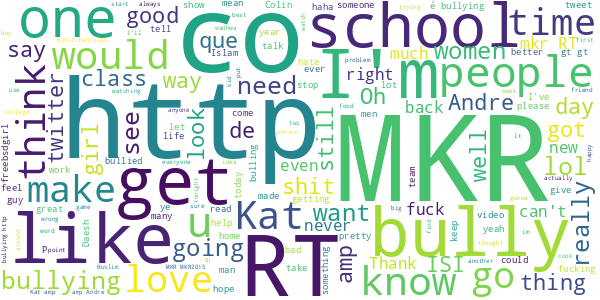

In [ ]:
print("Nube de palabras frecuentadas en tweets con categoría cyberbullying")
wordcloud.generate(txt_cb0)
wordcloud.to_image()

Nube de palabras frecuentadas en tweets sin categoría cyberbullying


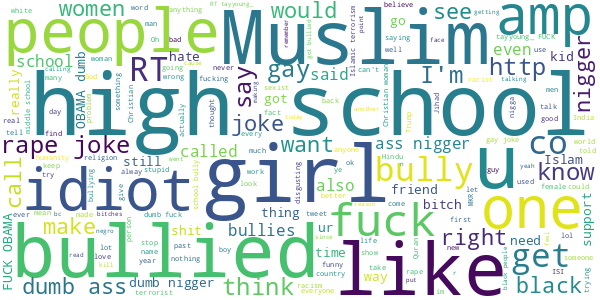

In [ ]:
print("Nube de palabras frecuentadas en tweets sin categoría cyberbullying")
wordcloud.generate(txt_cb1)
wordcloud.to_image()

La presencia de *high* y *school* como palabras importantes desvela la importancia de incluir bigramas que absorban la fuerza de ambos tokens individuales. Una lematización de las palabras bullied, bully o bullies distribuidas de manera sustancialmente distinta entre ambos grupos unificaria en un solo token al conjunto de palabras.

La presencia de la palabra bullies tambien demuestra el fracaso de la normalización de plurales del modulo wordcloud en este caso.

## 3. Preprocesado y Normalización

### Eliminación de espacios

In [ ]:
def eliminar_espacios(text):
    return  " ".join(text.split())

def texto_to_lower(text):
  return text.lower()

In [ ]:
dataset["normalized"] = dataset["tweet_text"].apply(lambda x: eliminar_espacios(x))
dataset["normalized"] = dataset["normalized"].apply(lambda x: texto_to_lower(x))

### Sustitución de contracciones, creación de una variable de conteo y análisis de su significancia mediante su representación

In [ ]:
def replace_contraction(text):
    return contractions.fix(text, slang=True)

for i, n in dataset["normalized"].items():
      dataset.at[i, "discontracted"] = replace_contraction(n)
      d = dataset.at[i, "discontracted"]
      n_contractions = len(set(d.split()) - set(n.split()))
      dataset.at[i, "n_contractions"] = int(n_contractions)

dataset = dataset.drop(columns=["normalized"])

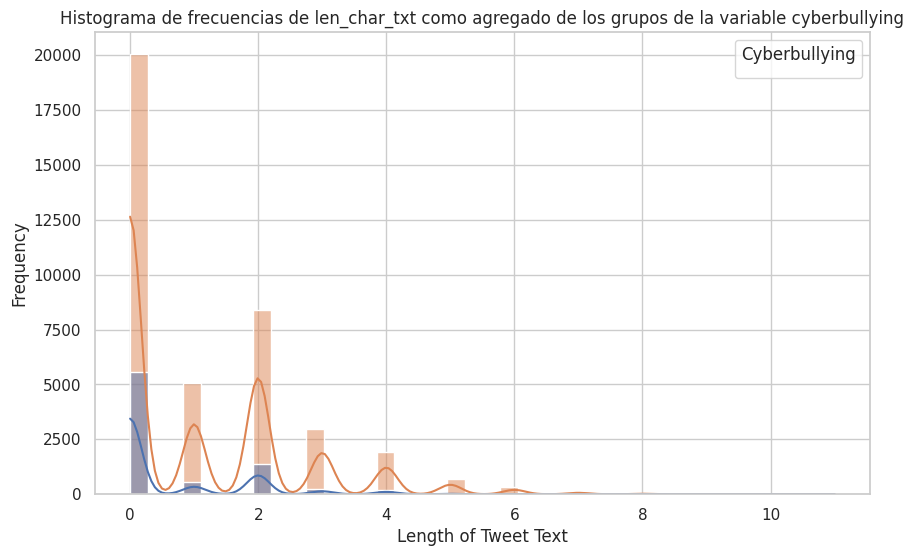

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=dataset, x="n_contractions", hue="cyberbullying", bins=40, kde=True)

plt.xlabel("Length of Tweet Text")
plt.ylabel("Frequency")
plt.title("Histograma de frecuencias de len_char_txt como agregado de los grupos de la variable cyberbullying")

plt.legend(title="Cyberbullying")
plt.show()

El número de contracciones contenidas en un documento no muestra una gran significancia graficamente.

### Tokenización y normalización de urls, menciones y números.

Usamos un tokenizador especifico para twitter



In [ ]:
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

def normalizar_tokens(documento):
    palabras =  tweet_tokenizer.tokenize(documento)
    for i in range(len(palabras)):
        if palabras[i].startswith("http://") or palabras[i].startswith("https://") or palabras[i].startswith("www."):
            palabras[i] = "URL"
        elif palabras[i].startswith("@"):
            palabras[i] = "MENTION"
        elif palabras[i].isdigit():
            palabras[i] = "NUM"

    documento_modificado = palabras

    return documento_modificado

Aplicamos la función generada a cada uno de los elementos de la muestra

In [ ]:
dataset["discontracted"] = dataset["discontracted"].apply(lambda x: normalizar_tokens(x))

Vemos el impacto en el dataset

In [ ]:
dataset.head()

,tweet_text,cyberbullying,len_char_txt,len_150,discontracted,n_contractions
0,"In other words #katandandre, your food was cra...",0,61,0,"[in, other, words, #katandandre, ,, your, food...",0.0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,115,0,"[why, is, #aussietv, so, white, ?, #mkr, #theb...",0.0
2,@XochitlSuckkks a classy whore? Or more red ve...,0,60,0,"[MENTION, a, classy, whore, ?, or, more, red, ...",0.0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0,103,0,"[MENTION, meh, ., :p, thanks, for, the, heads,...",0.0
4,@RudhoeEnglish This is an ISIS account pretend...,0,103,0,"[MENTION, this, is, an, isis, account, pretend...",0.0


### Supresión de stopwords

In [ ]:
def quitar_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [w for w in tokens if not w in stop_words]
    return filtered_sentence

In [ ]:
dataset["discontracted"] = dataset["discontracted"].apply(lambda x: quitar_stopwords(x))

### Creación de variables de conteo de los elementos previamente normalizados

In [ ]:
def token_appearance(document, token = "MENTION"):
  return len([x for x in document if x == token])

In [ ]:
dataset["num_mention"] = dataset["discontracted"].apply(lambda x: token_appearance(x, token="MENTION"))
dataset["num_URLS"] = dataset["discontracted"].apply(lambda x: token_appearance(x, token="URL"))
dataset["num_NUM"] = dataset["discontracted"].apply(lambda x: token_appearance(x, token="NUM"))

In [ ]:
dataset.head()

,tweet_text,cyberbullying,len_char_txt,len_150,discontracted,n_contractions,num_mention,num_URLS,num_NUM
0,"In other words #katandandre, your food was cra...",0,61,0,"[words, #katandandre, ,, food, crapilicious, !...",0.0,0,0,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,115,0,"[#aussietv, white, ?, #mkr, #theblock, #imacel...",0.0,0,0,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0,60,0,"[MENTION, classy, whore, ?, red, velvet, cupca...",0.0,1,0,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0,103,0,"[MENTION, meh, ., :p, thanks, heads, ,, concer...",0.0,1,0,0
4,@RudhoeEnglish This is an ISIS account pretend...,0,103,0,"[MENTION, isis, account, pretending, kurdish, ...",0.0,1,0,0


### Creación de variable de conteo de hastags

In [ ]:
 def hastagcounter(document):
  counter = 0
  for i in range(len(document)):
        if document[i].startswith("#"):
            counter += 1
  return counter

dataset["num_hastags"] = dataset["discontracted"].apply(lambda x: hastagcounter(x))

### Reunificación a string de la lista de tokens para posterior lematización de estos

In [ ]:
dataset["discontracted"] = dataset["discontracted"].apply(lambda x: " ".join(x))
dataset["discontracted"]

0            words #katandandre , food crapilicious ! #mkr
1        #aussietv white ? #mkr #theblock #imacelebrity...
2             MENTION classy whore ? red velvet cupcakes ?
3        MENTION meh . :p thanks heads , concerned anot...
4        MENTION isis account pretending kurdish accoun...
                               ...                        
47687    black people expected anything , depended anyt...
47688    turner withhold disappointment . turner called...
47689    swear god . dumb nigger bitch . got bleach hai...
47690    yea fuck rt MENTION : nigger fucking unfollow ...
47691    bro . got chill rt MENTION : dog fuck kp dumb ...
Name: discontracted, Length: 47449, dtype: object

In [ ]:
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

def lematizar(frase):
  lematizado = [ word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in nlp(frase) ]
  return " ".join(lematizado)

dataset["discontracted"] = dataset["discontracted"].apply(lambda x: lematizar(x))

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [ ]:
dataset.head()

,tweet_text,cyberbullying,len_char_txt,len_150,discontracted,n_contractions,num_mention,num_URLS,num_NUM,num_hastags
0,"In other words #katandandre, your food was cra...",0,61,0,"word # katandandre , food crapilicious ! # mkr",0.0,0,0,0,2
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,115,0,# aussietv white ? # mkr # theblock # imaceleb...,0.0,0,0,0,10
2,@XochitlSuckkks a classy whore? Or more red ve...,0,60,0,MENTION classy whore ? red velvet cupcake ?,0.0,1,0,0,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0,103,0,"MENTION meh . :p thank head , concern another ...",0.0,1,0,0,0
4,@RudhoeEnglish This is an ISIS account pretend...,0,103,0,MENTION isis account pretend kurdish account ....,0.0,1,0,0,0


## 4. Vectorización

### Vectorización TfIdf

Como ya cambiamos lowercase y quitamos stop_words previamente, lo desactivamos

In [ ]:
vectorizador = TfidfVectorizer(lowercase = False, stop_words =None, ngram_range=(1,3), min_df = 0.005)

In [ ]:
vector_data = vectorizador.fit_transform(dataset["discontracted"])

In [ ]:
vector_data

<47449x412 sparse matrix of type '<class 'numpy.float64'>'
	with 394281 stored elements in Compressed Sparse Row format>

## 5. Entrenamiento y evaluación de modelos


### Separamos las variables relevantes establecidas en el dataset inicial

In [ ]:
extra_features = dataset[['num_mention','num_URLS','num_NUM']]

### Establecimiento de variables dependientes e independientes

In [ ]:
y = dataset["cyberbullying"].values.astype(np.float32)
X = sp.sparse.hstack((vector_data,extra_features.values),format='csr')

In [ ]:
vector_data

<47449x412 sparse matrix of type '<class 'numpy.float64'>'
	with 394281 stored elements in Compressed Sparse Row format>

Con respecto a los vectores tokenizados (412) se añaden las 3 nuevas variables "extra_features"




In [ ]:
X

<47449x415 sparse matrix of type '<class 'numpy.float64'>'
	with 420871 stored elements in Compressed Sparse Row format>

### Creación de particiones de entrenamiento y testeo estratificados por la variable dependiente

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,
                                                    random_state=0,
                                                    stratify = y)
print(X_train.shape)
print(X_test.shape)

(35586, 415)
(11863, 415)


Observamos, como ya se podía preveer previamente, que la muestra está desbalanceada. Debemos evitar eso con un rebalanceo porque pruebas previas de predicción muestran un aumento desmedido en error de falsos positivos, que ya cabía esperar como resultado de este desbalanceo.

### Rebalanceo y guardado en nuevas variables de las muestras de entrenamiento

In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

### Generamos funcion de validación cruzada para la evaluación de los modelos

In [ ]:
def model_evaluation(models, score, X, y):
      results = []
      names = []
      for name, model in models:
          warnings.filterwarnings('ignore')
          KF = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 98)
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)

          results.append(cv_results)
          names.append(name)

          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

### Definimos los modelos a testear y los evaluamos

Como se observa en el siguiente bloque, el uso de los mismos modelos con la muestra rebalanceada generada previamente tiene un impacto sustancial en *GaussianNB* y *RandomForest*, y un impacto sutil en *Logistic*.

In [ ]:
models = [
         ("Logistic",LogisticRegression(random_state=30)),
         ("GaussianNB",GaussianNB()),
         ("RandomForest", RandomForestClassifier())
]

evaluation_score = "accuracy"

model_evaluation(models,  evaluation_score, X_res.toarray(), y_res)

Metric: accuracy , KFold 
Logistic: 0.861098 (0.003503) 
Metric: accuracy , KFold 
GaussianNB: 0.796464 (0.003654) 
Metric: accuracy , KFold 
RandomForest: 0.900543 (0.003313) 


([array([0.85525095, 0.86132434, 0.86628986, 0.86148136, 0.86114392]),
  array([0.78920287, 0.79898777, 0.79778978, 0.79838029, 0.7979585 ]),
  array([0.89557149, 0.89995782, 0.90593892, 0.90003374, 0.90121478])],
 ['Logistic', 'GaussianNB', 'RandomForest'])

### Generamos un análisis de hiperparámetros del modelo Random Forest por obtener los mejores resultados previamente con respecto al resto de opciones.

In [ ]:
model = RandomForestClassifier()
n_estimators = [10,100]
max_features = ['log2', 'sqrt']
min_samples_leaf = [1, 2]
min_samples_split = [2, 5]

In [ ]:
grid = dict(n_estimators=n_estimators,max_features=max_features,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

In [ ]:
grid_result = grid_search.fit(X_res, y_res)
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor accuracy: 0.905690 usando los parámetros {'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


### Ajustamos a la muestra el modelo óptimo de acuerdo al análisis de hiperparámetros.

In [ ]:
model=RandomForestClassifier(max_features = "log2" ,min_samples_leaf= 1, min_samples_split= 2, n_estimators = 100)
model.fit(X_res,y_res)

RandomForestClassifier(max_features='log2')

### Llevamos a cabo la predicción de la variable dependiente con el modelo elegido

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1249  735]
 [1339 8540]]
              precision    recall  f1-score   support

         0.0       0.48      0.63      0.55      1984
         1.0       0.92      0.86      0.89      9879

    accuracy                           0.83     11863
   macro avg       0.70      0.75      0.72     11863
weighted avg       0.85      0.83      0.83     11863



### Importancia de características

Al tratarse de un random forest existen varias maneras de medir la importancia de la característica, en este caso usaremos el tiempo de refinamiento.

In [ ]:
import time

import numpy as np

start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.143 seconds


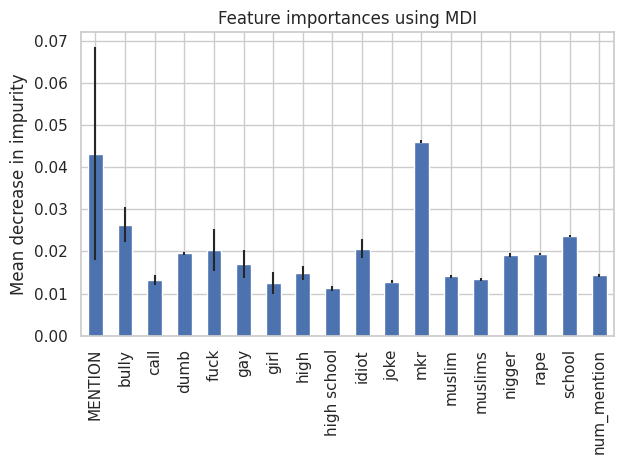

In [ ]:
X_columns=list(vectorizador.get_feature_names_out())+extra_features.columns.tolist()
forest_importances = pd.Series(importances, index=X_columns)
forest_importances = forest_importances [forest_importances >= 0.01]

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=np.array(std)[:len(forest_importances)], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Las menciones y las palabras *mkr*, *bully*, *school*, *fuck* e *idiot* son algunas de las más relevantes para explicar la presencia de ciberbullying dentro de tweets.

## Conclusiones

Obtenemos una predicción razonablemente acertada que nos hace concluir con el modelo de esa predicción si bien existirían bastantes más opciones para profundizar en el análisis.

La presencia de falta de concordancia a la hora de etiquetar la variable dependiente entre los responsables de hacerlo nos impide llegar a una predicción total. Un análisis exploratorio que examinase la proporción en la que tweets duplicados tienen valores contrarios entorno a su clasificación con respecto al total nos mostraría el error de muestreo que ya estaría absorbiendo el modelo, si bien el error podría aumentar en predicciones de muestras alternativas si este existe tambien en elementos no duplicados.

Una revisión rápida de la muestra tweets desvela una presencia muy reducida de emojis, lo que nos lleva a dejar al margen en un primer momento el análisis de sentimiento de estos.

La falta de presencia de emojis escritos con simbolos de puntuación en la última gráfica de relevancia de características del modelo final nos demuestra que no es realmente importante el mantenimiento de simbolos de puntuación del modelo lo que nos podría haber llevado a un refinamiento mayor de este de haberlos eliminado.

